In [202]:
import cv2
import numpy as np
import pickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Let us first read the train and test files

In [203]:
train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('train_labels.dat','rb')) 
test_labels = pickle.load(open('test_labels.dat','rb'))

In [204]:
train_images_filenames[12]

'../MIT_split/train/Opencountry/fie26.jpg'

In [205]:
import os

for file in range(len(train_images_filenames)):
    train_images_filenames[file] = train_images_filenames[file][3:]

for file in range(len(test_images_filenames)):
    test_images_filenames[file] = test_images_filenames[file][3:]

In [206]:
train_images_filenames[12]

'MIT_split/train/Opencountry/fie26.jpg'

### SIFT detector creation
We decide to use SIFT detector because it was the best method we used on C1 Module.

The number of features has been optimized to maximize the accuracy of the method using Optuna. 

C:\Users\maria\AppData\Local\Temp\ipykernel_8664\1186665648.py:3: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)


Best Trial: {'nfeatures': 1750}


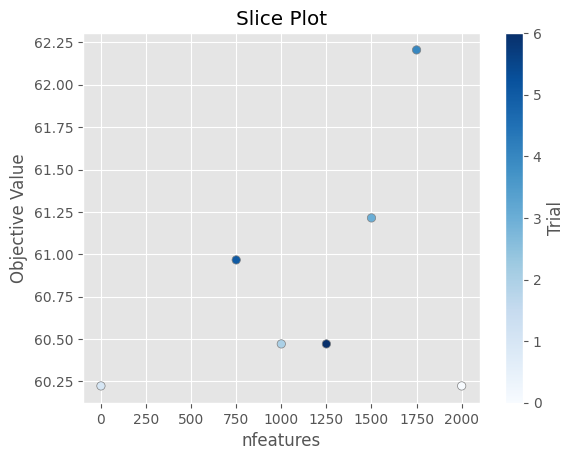

In [207]:
study = optuna.load_study(storage="sqlite:///c3_task1.db", study_name="siftV0")

optuna.visualization.matplotlib.plot_slice(study)


# Get the best hyperparameters
best_trial = study.best_trial
best_params = best_trial.params
print(f"Best Trial: {best_params}")


The highest accuracy = 62,21% has been obtained with a maximum limitation of 1750 local features per image.

In [208]:
Detector = cv2.SIFT_create(nfeatures=1750)

### Descriptor Mode Selection
Select if use standard descritptor, dense descriptor or both. Change to True the descriptors you want to use and to False the others.

In [209]:
dense_descriptor = True
standard_descriptor = True

### Dense SIFT: 
This method has been applied with one hyperparameter to be optimized:
- kpt_size = the size of the keypoint (scale)

Optuna has been used to find the keypoint size that acquires a highest accuracy. These best hyperparameter is:

C:\Users\maria\AppData\Local\Temp\ipykernel_8664\925824665.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)


Best Trial: {'kpt_size': 14}
Best Value: 77.81908302354398


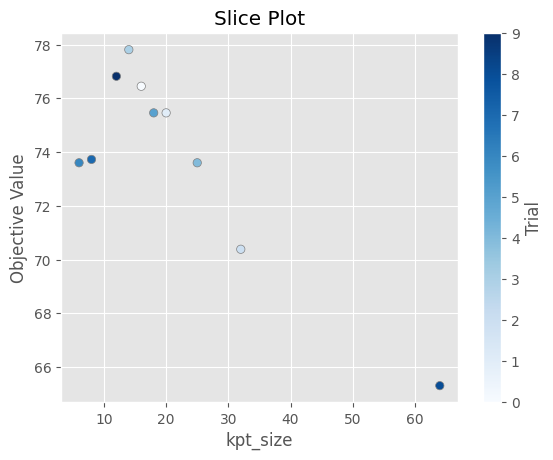

In [210]:
study = optuna.load_study(storage="sqlite:///c3_task1.db", study_name="siftV3")
optuna.visualization.matplotlib.plot_slice(study)

# Get the best hyperparameter
best_trial = study.best_trial
print(f"Best Trial: {best_trial.params}")
print(f"Best Value: {best_trial.value}")

#### Dense SIFT function:
First all keypoints are obtained using the hyperparameters. Then, the SIFT descriptor is applied on each keypoint and the descriptors are returned.

In [211]:
def dense_sift(img, keypoint_size=14):
    # Compute SIFT descriptors at each grid point
    h, w = img.shape
    margin = int(keypoint_size/2)
    keypoints = [cv2.KeyPoint(x, y, keypoint_size) for y in range(margin, h, keypoint_size) for x in range(margin, w, keypoint_size)]
    _, descriptors = Detector.compute(img, keypoints)

    return keypoints, descriptors

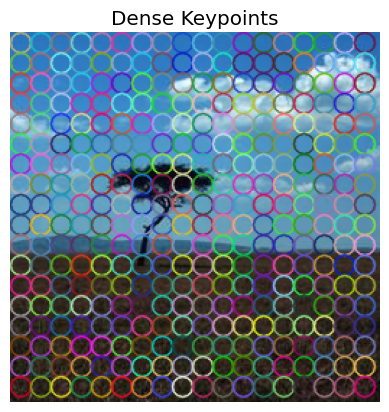

In [212]:
filename = train_images_filenames[1]
image=cv2.imread(filename)
gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

keypoints, _ = dense_sift(gray, keypoint_size=14)

# Draw keypoints on the image
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the result
plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Dense Keypoints')
plt.axis('off')
plt.show()

### L2 Normalize descriptors
The purpose of normalizing descriptors, especially in the context of feature matching, is to make the descriptors invariant to scale variations. Normalization can improve the robustness of matching algorithms by making them less sensitive to changes in overall intensity or scale of the features across different images.

In [213]:
normalize = False
def l2_normalize(descriptor):
    if normalize:
        norm = np.linalg.norm(descriptor)
        if norm == 0:
            return descriptor
        return descriptor/norm
    return descriptor

### Descriptors of the Training Dataset
We compute the  descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together for both SIFT and dense SIFT.

In [214]:
Train_descriptors = []
Train_dense_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

    # Training descriptors for standard SIFT
    if standard_descriptor:
        kpt,des=Detector.detectAndCompute(gray,None)
        Train_descriptors.append(l2_normalize(des))

    # Training descriptors for dense SIFT
    if dense_descriptor:
        d_kpt,d_des = dense_sift(gray)
        Train_dense_descriptors.append(l2_normalize(d_des))

    Train_label_per_descriptor.append(labels)
    
D=np.vstack(Train_descriptors) if standard_descriptor else 0
dense_D=np.vstack(Train_dense_descriptors) if dense_descriptor else 0

### K-Means clustering
We now compute a k-means clustering on the descriptor space

In [215]:
k = 128
if standard_descriptor:
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D) 
    
if dense_descriptor:
    d_codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    d_codebook.fit(dense_D)

c:\Users\maria\Desktop\C3\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\maria\Desktop\C3\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


### Create Training Visual words for BOVW
And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [216]:
if standard_descriptor:
    visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
    for i in range(len(Train_descriptors)):
        words=codebook.predict(Train_descriptors[i])
        visual_words[i,:]=np.bincount(words,minlength=k)

if dense_descriptor:
    d_visual_words=np.zeros((len(Train_dense_descriptors),k),dtype=np.float32)
    for i in range(len(Train_dense_descriptors)):
        d_words=d_codebook.predict(Train_dense_descriptors[i])
        d_visual_words[i,:]=np.bincount(d_words,minlength=k)

### K-NN Classifier
We build a k-nn classifier and train it with the train descriptors

In [217]:
if standard_descriptor:
    knn = KNeighborsClassifier(n_neighbors=8,n_jobs=-1,metric='euclidean')
    knn.fit(visual_words, train_labels) 
if dense_descriptor:
    d_knn = KNeighborsClassifier(n_neighbors=8,n_jobs=-1,metric='euclidean')
    d_knn.fit(d_visual_words, train_labels) 

### Descriptors from Test Dataset
We end up computing the test descriptors and compute the accuracy of both SIFT and dense SIFT models.

In [218]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_dense_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

    # Test descriptors for standard SIFT
    if standard_descriptor:
        kpt,des=Detector.detectAndCompute(gray,None)
        words=codebook.predict(l2_normalize(des))
        visual_words_test[i,:]=np.bincount(words,minlength=k)

    # Test descriptors for dense SIFT
    if dense_descriptor:
        d_kpt,d_des = dense_sift(gray)
        dense_words=d_codebook.predict(l2_normalize(d_des))
        visual_words_dense_test[i,:]=np.bincount(dense_words,minlength=k)

In [219]:
if standard_descriptor:
    accuracy = 100*knn.score(visual_words_test, test_labels)
    print(f"SIFT accuracy: {accuracy}")
if dense_descriptor:
    dense_accuracy = 100*d_knn.score(visual_words_dense_test, test_labels)
    print(f"Dense SIFT accuracy: {dense_accuracy}")

SIFT accuracy: 62.20570012391574
Dense SIFT accuracy: 77.81908302354398


For categorization the dense SIFT method is more suitable because it takes into account elements of the background that are not relevant for the SIFT method but are still useful to determine which category each image belongs to.

Without Normalization:
- SIFT accuracy: 62.20570012391574
- Dense SIFT accuracy: 77.81908302354398

With L2 Normalization:
- SIFT accuracy: 60.09913258983891
- Dense SIFT accuracy: 76.95167286245353

### Dimensionality reduction, with PCA and LDA

#### PCA
PCA aims to maximize the variance in the data. It tends to capture global structures and patterns in the data, but it might not preserve class-specific information well. It might mix information from different classes, leading to reduced discriminative power. That could be the reason for the reduction in accuracy obtained after applying PCA to our problem.

In [220]:
if standard_descriptor:
    pca = PCA(n_components=64)
    VWpca = pca.fit_transform(visual_words)
    knnpca = KNeighborsClassifier(n_neighbors=8,n_jobs=-1,metric='euclidean')
    knnpca.fit(VWpca, train_labels) 
    vwtestpca = pca.transform(visual_words_test)
    accuracy = 100*knnpca.score(vwtestpca, test_labels)
    print(f"SIFT accuracy: {accuracy}")

if dense_descriptor:
    pca = PCA(n_components=64)
    VWpca = pca.fit_transform(d_visual_words)
    knnpca = KNeighborsClassifier(n_neighbors=8,n_jobs=-1,metric='euclidean')
    knnpca.fit(VWpca, train_labels) 
    vwtestpca = pca.transform(visual_words_dense_test)
    accuracy = 100*knnpca.score(vwtestpca, test_labels)
    print(f"Dense SIFT accuracy: {accuracy}")

SIFT accuracy: 61.957868649318456
Dense SIFT accuracy: 76.70384138785626


Without Normalization:
- SIFT accuracy: 61.957868649318456
- Dense SIFT accuracy: 76.70384138785626

With L2 Normalization:
- SIFT accuracy: 56.25774473358116
- Dense SIFT accuracy: 75.71251548946717

#### LDA
LDA considers class information during dimensionality reduction. It aims to maximize the distance between class means while minimizing the spread within each class. This can lead to better separation between classes. Since our data has a clear class structure, LDA is more effective and improves the accuracy to our problem.

In [221]:
if standard_descriptor:
    lda = LinearDiscriminantAnalysis(n_components=7)
    VWlda = lda.fit_transform(visual_words,train_labels)
    knnlda = KNeighborsClassifier(n_neighbors=8,n_jobs=-1,metric='euclidean')
    knnlda.fit(VWlda, train_labels) 
    vwtestlda = lda.transform(visual_words_test)
    accuracy = 100*knnlda.score(vwtestlda, test_labels)
    print(f"SIFT accuracy: {accuracy}")

if dense_descriptor:
    lda = LinearDiscriminantAnalysis(n_components=7)
    VWlda = lda.fit_transform(d_visual_words,train_labels)
    knnlda = KNeighborsClassifier(n_neighbors=8,n_jobs=-1,metric='euclidean')
    knnlda.fit(VWlda, train_labels) 
    vwtestlda = lda.transform(visual_words_dense_test)
    accuracy = 100*knnlda.score(vwtestlda, test_labels)
    print(f"Dense SIFT accuracy: {accuracy}")

SIFT accuracy: 66.54275092936803
Dense SIFT accuracy: 80.04956629491944


Without L2 Normalization:
- SIFT accuracy: 66.54275092936803
- Dense SIFT accuracy: 80.04956629491944

With L2 Normalization:
- SIFT accuracy: 62.70136307311029
- Dense SIFT accuracy: 81.04089219330855

#### Normalization effect

L2 normalization can sometimes reduce the discriminative power of descriptors, especially if the original scale of the features carries meaningful information for classification. In some cases, normalization might lead to loss of information. Dense SIFT might capture more global and structured information from the images, making it less sensitive to normalization and potentially more amenable to dimensionality reduction. On the other hand, normalization lead to loss of information when using SIFT.